In [1]:
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft
import glob

In [2]:
def remove_periodic(X, df_index, detrending=True, model='additive', frequency_threshold=0.1e12):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    else:
        rad_trends = rad_series_clean
        
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    #rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    residual = rad - rad_clean_ts.values
    clean = rad_clean_ts.values
    return residual, clean

In [3]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="datetime",parse_dates=['datetime'], header=0, sep=",")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    frame = frame.fillna(method='ffill')
    return frame

In [4]:
def create_spatio_temporal_data(nrel_df):
    lat = [21.31236,21.31303,21.31357,21.31183,21.31042,21.31268,21.31451,21.31533,21.30812,21.31276,21.31281,21.30983,21.31141,21.31478,21.31179,21.31418,21.31034]
    lon = [-158.08463,-158.08505,-158.08424,-158.08554,-158.0853,-158.08688,-158.08534,-158.087,-158.07935,-158.08389,-158.08163,-158.08249,-158.07947,-158.07785,-158.08678,-158.08685,-158.08675]
    additional_info = pd.DataFrame({'station': df.columns, 'latitude': lat, 'longitude': lon })
    ll = []
    for ind, row in nrel_df.iterrows():
        for col in nrel_df.columns:
            lat = additional_info[(additional_info.station == col)].latitude.values[0]
            lon = additional_info[(additional_info.station == col)].longitude.values[0]
            irradiance = row[col]
            ll.append([lat, lon, irradiance])  

    return pd.DataFrame(columns=['latitude','longitude','irradiance'], data=ll)

In [4]:
path = '/Users/cseveriano/spatio-temporal-forecasting/data/processed/NREL/Oahu'

df = load_data(path)

# Corrigir ordem das colunas
df.columns = ['DHHL_3','DHHL_4', 'DHHL_5', 'DHHL_10', 'DHHL_11', 'DHHL_9', 'DHHL_2', 'DHHL_1', 'DHHL_1_Tilt', 'AP_6', 'AP_6_Tilt', 'AP_1', 'AP_3', 'AP_5', 'AP_4', 'AP_7', 'DHHL_6', 'DHHL_7', 'DHHL_8']
#inicio dos dados possui falhas na medicao
df = df.loc[df.index > '2010-03-20']
df.drop(['DHHL_1_Tilt', 'AP_6_Tilt'], axis=1, inplace=True)

## Preparação bases de treinamento e testes

In [5]:
clean_df = pd.DataFrame(columns=df.columns, index=df.index)
residual_df = pd.DataFrame(columns=df.columns, index=df.index)

for col in df.columns:
    residual, clean = remove_periodic(df[col].tolist(), df.index, frequency_threshold=0.01e12)
    clean_df[col] = clean.tolist()
    residual_df[col] = residual.tolist()

In [6]:
train_df = df[(df.index >= '2010-09-01') & (df.index <= '2011-09-01')]
train_clean_df = clean_df[(clean_df.index >= '2010-09-01') & (clean_df.index <= '2011-09-01')]
train_residual_df = residual_df[(residual_df.index >= '2010-09-01') & (residual_df.index <= '2011-09-01')]


test_df = df[(df.index >= '2010-08-05')& (df.index < '2010-08-06')]
test_clean_df = clean_df[(clean_df.index >= '2010-08-05')& (clean_df.index < '2010-08-06')]
test_residual_df = residual_df[(residual_df.index >= '2010-08-05')& (residual_df.index < '2010-08-06')]

In [8]:
train_residual_df.head()

,DHHL_3,DHHL_4,DHHL_5,DHHL_10,DHHL_11,DHHL_9,DHHL_2,DHHL_1,AP_6,AP_1,AP_3,AP_5,AP_4,AP_7,DHHL_6,DHHL_7,DHHL_8
datetime,,,,,,,,,,,,,,,,,
2010-09-01 05:00:00,41.524779,37.241017,57.049132,27.679583,47.497538,50.920165,72.683784,101.006040,36.740957,-310.405128,-97.253805,36.753792,29.994538,6.264827,60.721038,77.327826,80.065566
2010-09-01 05:15:00,35.445270,28.944421,48.903710,19.280622,35.855764,45.935509,65.485102,91.860528,32.635776,-36.656994,28.346678,30.392091,24.981971,58.695178,52.888593,67.912556,70.479768
2010-09-01 05:30:00,28.392311,19.113065,39.179198,9.003664,21.979622,39.862161,55.824578,79.881736,26.939398,15.267552,-101.992396,22.632457,17.976379,-72.730689,42.809822,55.759055,58.128172
2010-09-01 05:45:00,19.235364,6.858255,26.992848,-4.135749,5.129014,31.473775,42.768295,64.081153,18.360350,61.961674,-34.844894,12.666130,7.922233,72.728706,29.455063,40.180358,42.359652
2010-09-01 06:00:00,7.717017,-7.455698,12.356655,-19.575219,-14.143846,20.520012,26.654418,44.587741,6.110437,17.084733,130.668549,1.012905,-4.676898,189.935547,13.311147,21.056204,23.187325


In [8]:
# ms_df = create_spatio_temporal_data(train_residual_df)
# ms_df.to_pickle("cluster_df.pkl")

In [49]:
ms_df.to_pickle("cluster_all_stations_df.pkl")

In [9]:
#ms_df = pd.read_pickle("cluster_df.pkl")

In [9]:
ms_df = train_residual_df

In [50]:
test_residual_df.to_pickle("test_cluster_all_stations_df.pkl")

In [10]:
from sklearn import preprocessing

X = ms_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

## Mini-batch KMeans


In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [14]:
np.arange(10,100,10)

array([10, 20, 30, 40, 50, 60, 70])

Busca de melhor valor k com base no Sillouette Coefficient

Starting Loop
For n_clusters = 100 The average silhouette_score is : 0.0942383030357
For n_clusters = 200 The average silhouette_score is : 0.0811338631523
For n_clusters = 300 The average silhouette_score is : 0.0778474540897
For n_clusters = 400 The average silhouette_score is : 0.0745462728165


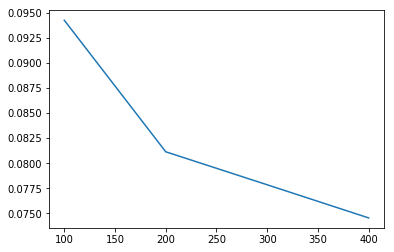

In [16]:
batch_size = 1000
init_size = 1000
#range_n_clusters = np.arange(2,40)
range_n_clusters = np.arange(100,500,100)
print("Starting Loop")
results = []

for n_clusters in range_n_clusters:

#     print("Starting Mini-batch")
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size, init_size=init_size,
                      n_init=1, verbose=False)
#     print("Starting Fit predict")
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
#     print("Starting Silhouette")
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
    results.append(silhouette_avg)

plt.plot(range_n_clusters,results)

Starting Loop
For n_clusters = 2 The within-cluster variance is : 2364.47457076
For n_clusters = 3 The within-cluster variance is : 1701.62239373
For n_clusters = 4 The within-cluster variance is : 1388.59329693
For n_clusters = 5 The within-cluster variance is : 1254.41898543
For n_clusters = 6 The within-cluster variance is : 1178.27743393
For n_clusters = 7 The within-cluster variance is : 1190.89442878
For n_clusters = 8 The within-cluster variance is : 1130.32466874
For n_clusters = 9 The within-cluster variance is : 1009.44035013
For n_clusters = 10 The within-cluster variance is : 1004.09512894
For n_clusters = 11 The within-cluster variance is : 930.352410874
For n_clusters = 12 The within-cluster variance is : 895.353359133
For n_clusters = 13 The within-cluster variance is : 863.291588626
For n_clusters = 14 The within-cluster variance is : 846.234302839
For n_clusters = 15 The within-cluster variance is : 830.45902028
For n_clusters = 16 The within-cluster variance is : 802.

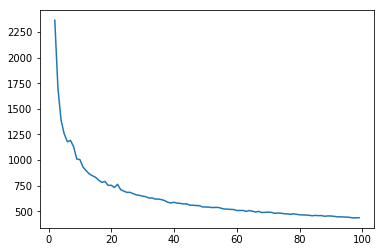

In [25]:
batch_size = 1000
init_size = 1000
#range_n_clusters = np.arange(2,40)
range_n_clusters = np.arange(2,100)
print("Starting Loop")
results = []

for n_clusters in range_n_clusters:

#     print("Starting Mini-batch")
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size, init_size=3 * n_clusters,
                      n_init=1, verbose=False)
#     print("Starting Fit predict")
    cluster_labels = clusterer.fit_predict(X)

    print("For n_clusters =", n_clusters,"The within-cluster variance is :", clusterer.inertia_)
    results.append( clusterer.inertia_ )

plt.plot(range_n_clusters,results)

In [25]:
print("Best value: ",max(results), "Number of clusters: ", range_n_clusters[np.argmax(results)])

Best value:  0.966338545956 Number of clusters:  17


For n_clusters = 20 The average silhouette_score is : 0.133200836895


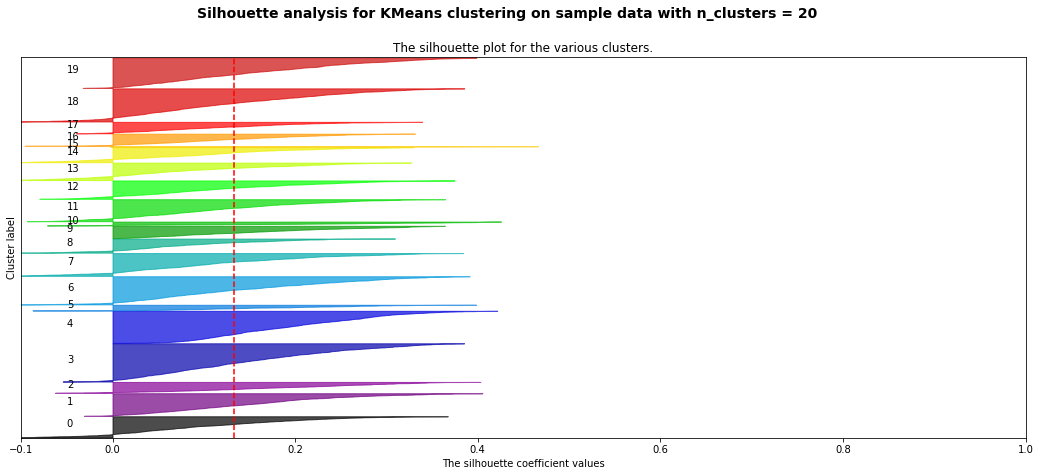

In [26]:
import matplotlib.cm as cm

n_clusters = 20
n_samples = 10000
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, n_samples + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size, init_size=init_size,
                      n_init=1, verbose=False)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels, sample_size=n_samples)
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

idx = np.random.choice(np.arange(len(X)), n_samples, replace=False)
x_sample = X[idx]
c_sample = cluster_labels[idx]


sample_silhouette_values = silhouette_samples(x_sample, c_sample)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[c_sample == i]


    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [27]:
from scipy.stats import truncnorm

In [28]:
a, b = 0.1, 2
mean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk')


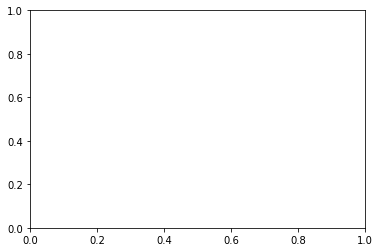

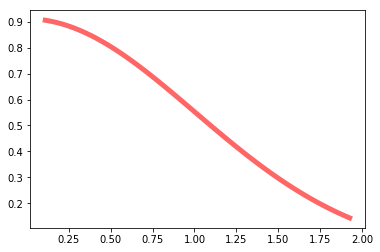

In [37]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(truncnorm.ppf(0.01, a, b), truncnorm.ppf(0.99, a, b), 100)

ax.plot(x, truncnorm.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='truncnorm pdf')

In [40]:
from pyFTS.common  import Membership

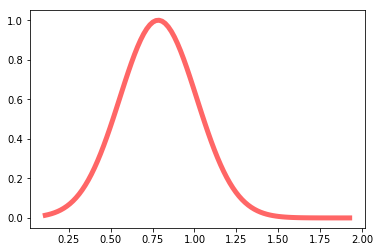

In [45]:
fig, ax = plt.subplots(1, 1)
y = [Membership.gaussmf(xx,[mean,var]) for xx in x]
ax.plot(x, y,'r-', lw=5, alpha=0.6, label='truncnorm pdf')

In [47]:
a, b = (myclip_a - mean) / my_std, (myclip_b - my_mean) / my_std

1.013202851929111

In [48]:
max(x)

1.9248453824582838